In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
#importamos LogisticRegression
from sklearn.linear_model import LogisticRegression

In [3]:

# Cargar el dataset
file_path = '../../dataset/s_farmacia.csv'
data = pd.read_csv(file_path, delimiter=';')


/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_15431/3330878829.py:3: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, delimiter=';')


In [4]:
data['CATEGORIA_FACTURA'].value_counts()

CATEGORIA_FACTURA
 1    351542
-1    103356
 2     56019
 0     50013
-2         1
Name: count, dtype: int64

In [16]:
data = data[data['CATEGORIA_FACTURA'] != -2]

In [17]:

# Convertir columnas de fechas a objetos datetime
date_columns = ['FECHA_FACTURA', 'MAX_FECHA_COBRO', 'FECHA_CONTABILIZACION']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extraer características de las fechas
for col in date_columns:
    data[col + '_YEAR'] = data[col].dt.year
    data[col + '_MONTH'] = data[col].dt.month
    data[col + '_DAY'] = data[col].dt.day
    data[col + '_WEEKDAY'] = data[col].dt.weekday

# Eliminar las columnas originales de fecha si ya no son necesarias
data.drop(columns=date_columns, inplace=True)

columns_to_drop = ['EMPRESA', 'NUMERO_FACTURA', 'NUMERO_ASIENTO_BORRADOR', 'TIPO_FACTURA', 'DIARIO', 'IMPORTE_COBRADO_FRA', 'CUENTA_CONTABLE','NUM_EFECTOS_COBRADOS', 'NUM_EFECTOS_PARCIAL', 'NUM_EFECTOS_IMPAGADO', 'NUM_EFECTOS_FUERA_PLAZO', 'NUM_EFECTOS_PDTE_EN_PLAZO']
data.drop(columns=columns_to_drop, inplace=True)

data.fillna(0, inplace=True)

# Convertir todas las entradas en las columnas categóricas a cadenas
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    data[column] = data[column].astype(str)

# Convertir columnas categóricas a variables numéricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Re-codificar las clases de la variable objetivo
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(data['CATEGORIA_FACTURA'])

# Separación de características y variable objetivo
X = data.drop('CATEGORIA_FACTURA', axis=1)

# Sobremuestreo de la clase minoritaria utilizando SMOTE
smote = SMOTE(random_state=42, k_neighbors=7, sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Función para evaluar el rendimiento de los modelos
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return [name, accuracy, precision, recall, f1]

# Lista para almacenar resultados
results = []

# Parámetros para GridSearchCV
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 20, 50],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 20, 40],
    'criterion': ['gini', 'entropy']
}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_62990/1843948297.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_62990/1843948297.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_62990/1843948297.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [18]:

# Árboles de Decisión
dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=cv, refit=True, verbose=2)
dt.fit(X_train, y_train)
results.append(evaluate_model("Árboles de Decisión", dt, X_test, y_test))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   5.9s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   6.3s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   5.7s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   5.6s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   6.1s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   5.7s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   6.2s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   5.6s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   5.7s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   6.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=10; total time=   5.6s
[CV] END criterion=gini, max_depth=None, min_sa

In [19]:
# Random Forest
rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=cv, refit=True, verbose=2)
rf.fit(X_train, y_train)
y_pred_rf = label_encoder_y.inverse_transform(rf.predict(X_test))
results.append(evaluate_model("Random Forest", rf, X_test, y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time= 1.6min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time= 1.5min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time= 1.5min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time= 1.5min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time= 1.5min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time= 3.0min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time= 3.0min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time= 3.0min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time= 3.2min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_est

In [20]:
# XGBoost
xgboost = GridSearchCV(xgb.XGBClassifier(), param_grid_xgb, cv=cv, refit=True, verbose=2)
xgboost.fit(X_train, y_train)
y_pred_xgb = label_encoder_y.inverse_transform(xgboost.predict(X_test))

results.append(evaluate_model("XGBoost", xgboost, X_test, y_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.4s
[CV] END

In [21]:
# K-Nearest Neighbors (K-NN)
knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=cv, refit=True, verbose=2)
knn.fit(X_train, y_train)
y_pred_knn = label_encoder_y.inverse_transform(knn.predict(X_test))
results.append(evaluate_model("K-Nearest Neighbors", knn, X_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  33.3s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  33.3s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  33.3s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  33.4s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  33.4s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  31.8s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  31.6s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  31.7s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  31.8s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  31.6s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=  33.3s
[CV] END ...metric=euclidean, n_neighbors=5, we

In [ ]:
# SVM con búsqueda de hiperparámetros
svm = GridSearchCV(SVC(), param_grid_svm, cv=cv, refit=True, verbose=2)
svm.fit(X_train, y_train)
y_pred_svm = label_encoder_y.inverse_transform(svm.predict(X_test))
results.append(evaluate_model("Support Vector Machine", svm, X_test, y_test))

In [22]:
svm = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("\nSupport Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))



Support Vector Machine:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21019
           1       0.95      0.98      0.96     70461
           2       0.92      0.93      0.92     69811
           3       0.79      0.52      0.63     11201

    accuracy                           0.93    172492
   macro avg       0.91      0.86      0.88    172492
weighted avg       0.93      0.93      0.93    172492

[[20932     0    87     0]
 [    0 69000  1330   131]
 [   49  3184 65145  1433]
 [    0   785  4595  5821]]


In [23]:
results.append(evaluate_model("Support Vector Machine", svm, X_test, y_test))


Support Vector Machine:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21019
           1       0.95      0.98      0.96     70461
           2       0.92      0.93      0.92     69811
           3       0.79      0.52      0.63     11201

    accuracy                           0.93    172492
   macro avg       0.91      0.86      0.88    172492
weighted avg       0.93      0.93      0.93    172492

[[20932     0    87     0]
 [    0 69000  1330   131]
 [   49  3184 65145  1433]
 [    0   785  4595  5821]]


In [24]:
# Stacking
estimators = [
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC()),
    ('knn', KNeighborsClassifier()),
    ('xgb', xgb.XGBClassifier())
]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking.fit(X_train, y_train)
results.append(evaluate_model("Stacking", stacking, X_test, y_test))


Stacking:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21019
           1       0.98      0.99      0.98     70461
           2       0.97      0.97      0.97     69811
           3       0.93      0.89      0.91     11201

    accuracy                           0.98    172492
   macro avg       0.97      0.96      0.97    172492
weighted avg       0.98      0.98      0.98    172492

[[21016     0     3     0]
 [    0 69590   850    21]
 [    5  1287 67764   755]
 [    0    60  1156  9985]]


stacking: 1234

svm: 512

knn: 149

xgb: 82

rf: 250

dt: 8 min


Tabla de comparación de modelos:
                   Modelo  Exactitud  Precisión    Recall  F1-Score
0     Árboles de Decisión   0.955430   0.955484  0.955430  0.955456
1           Random Forest   0.966462   0.966200  0.966462  0.965538
2                 XGBoost   0.981622   0.981579  0.981622  0.981585
3     K-Nearest Neighbors   0.937852   0.935105  0.937852  0.935631
4  Support Vector Machine   0.932785   0.929550  0.932785  0.929223
5                Stacking   0.976016   0.975878  0.976016  0.975919


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1200x800 with 0 Axes>

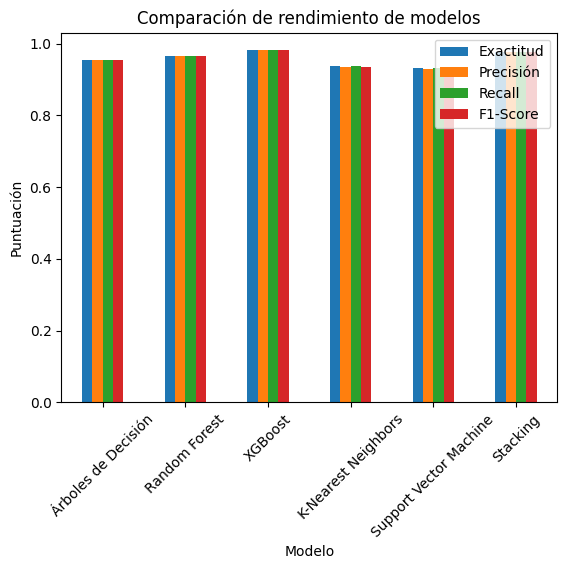

In [25]:

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results, columns=["Modelo", "Exactitud", "Precisión", "Recall", "F1-Score"])

# Mostrar la tabla de resultados
print("\nTabla de comparación de modelos:")
print(results_df)

# Graficar los resultados
plt.figure(figsize=(12, 8))
results_df.set_index("Modelo").plot(kind='bar')
plt.title('Comparación de rendimiento de modelos')
plt.ylabel('Puntuación')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show

In [ ]:
# XGBoost
xgboost = GridSearchCV(xgb.XGBClassifier(), param_grid_xgb, cv=cv, refit=True, verbose=2)
xgboost.fit(X_train, y_train)
y_pred_xgb = label_encoder_y.inverse_transform(xgboost.predict(X_test))

In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Precision, Recall, F1-Score (weighted, macro, micro)
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Log Loss
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        logloss = log_loss(y_test, y_pred_proba)
    else:
        logloss = None
    
    # ROC AUC Score (One-vs-Rest)
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    except:
        roc_auc = None
    
    # Print classification report and confusion matrix
    print(f"\n{name}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(cm)
    
    # Return all metrics
    return {
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Weighted)': precision_weighted,
        'Recall (Weighted)': recall_weighted,
        'F1-Score (Weighted)': f1_weighted,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1-Score (Macro)': f1_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Micro)': recall_micro,
        'F1-Score (Micro)': f1_micro,
        'Cohen\'s Kappa': kappa,
        'Log Loss': logloss,
        'ROC AUC': roc_auc
    }